# Chapter5. 오차역전파법

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100%!important;}</style>"))

In [2]:
from IPython.display import Image
import numpy as np

# 5.1 계산 그래프

- **계산그래프**: 계산 과정을 그래프로 나타낸 것, 노드와 에지로 표현
- **순전파**: 계산을 왼쪽에서 오른쪽으로 진행</br>**역전파**: 계산을 왼쪽에서 오른쪽으로 진행
- **계산 그래프를 쓰는 이유?**</br>전체 계산이 아무리 복잡해도 각 노드에서는 단순한(국소적) 계산에 집중하여 문제를 단순화 할 수 있음 </br>역전파를 통해 미분을 효율적으로 계산할 수 있음

## 5.2 연쇄법칙

합성함수의 미분: 합성 함수를 구성하는 각 함수의 미분의 곱을 구하면 된다!

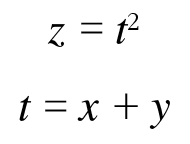

In [3]:
Image("image/e 5.1.png")

위의 수식에서 x에 대한 z의 미분값은 다음과 같이 구할 수 있음

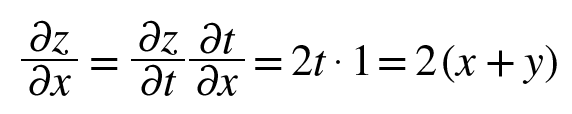

In [4]:
Image("image/e 5.4.png")

**=> 계산 노드에서 국소적 미분을 수행하고 오른쪽으로 왼쪽으로 신호를 전파하면서, 연쇄법칙에 따라 미분 값을 쉽게 구할 수 있다!**

## 5.3 역전파

### 5.3.1 덧셈 노드의 역전파

**Z = X+Y에서**

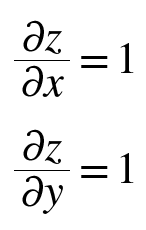

In [5]:
Image("image/e 5.5.png")

**각 변수에 대한 미분 값은 1이 됨!**

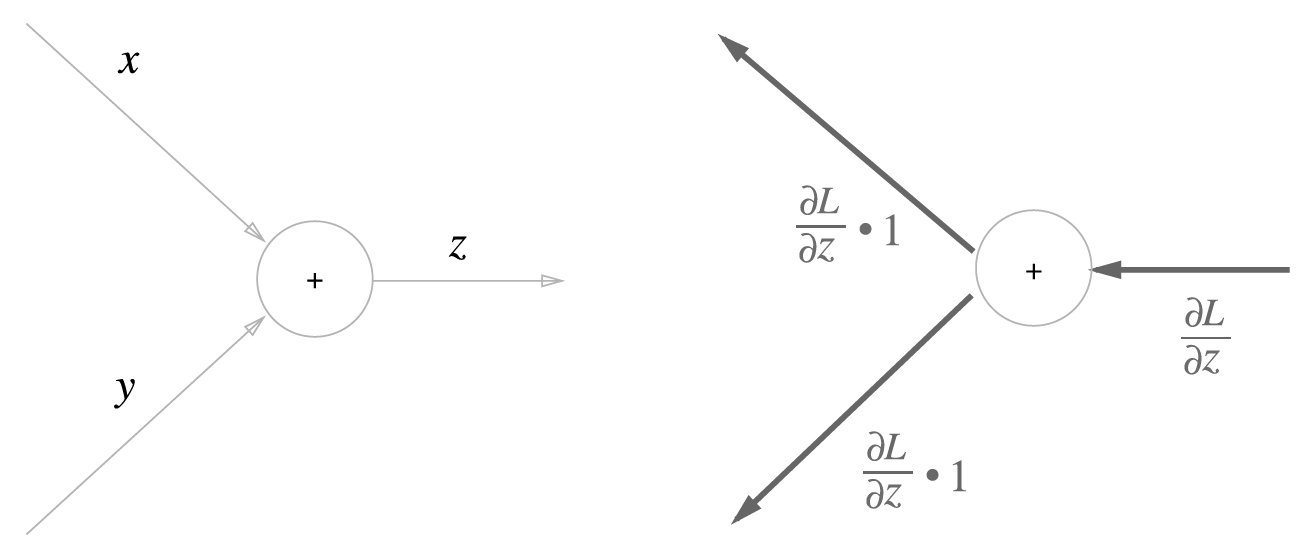

In [6]:
Image("image/fig 5-9.png")

따라서 상류에서 전해진 미분에 1을 곱하여 하류로 흘림 -> **덧셈 노드의 역전파는 입력 값을 그대로 흘려보낸다!**

### 5.3.2 곱셈 노드의 역전파

**Z=XY에서**

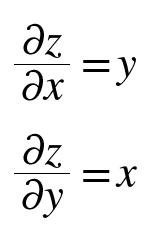

In [7]:
Image("image/e 5.6.png")

**각 변수에 대한 미분 값은 이전노드에서 입력된 또 다른 신호가 됨!**

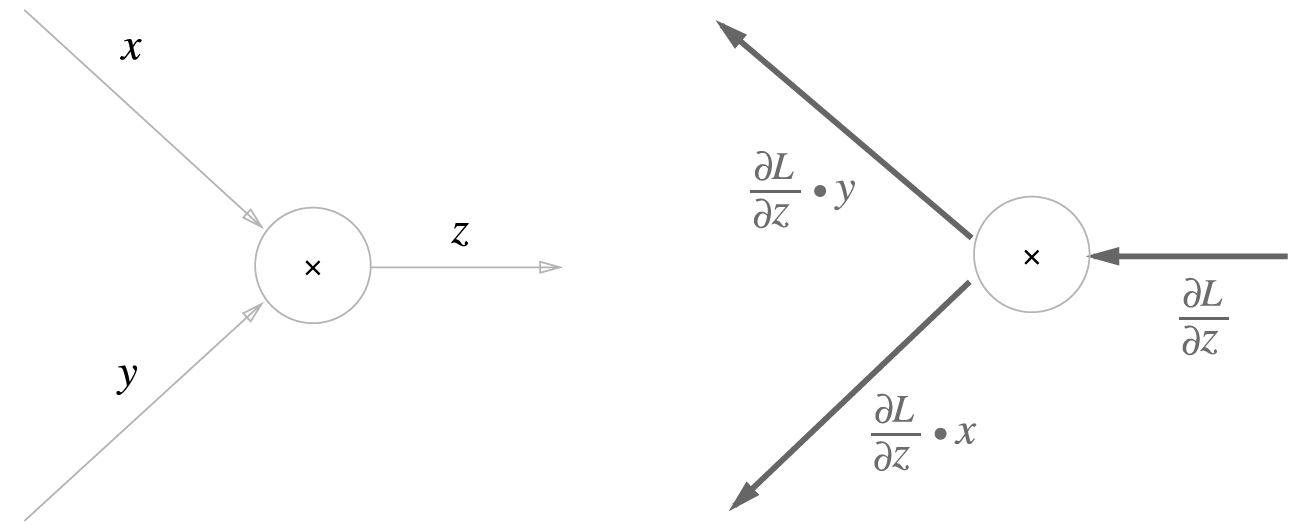

In [8]:
Image("image/fig 5-12.png")

-> 곱셈 노드 역전파는 **상류의 값에 순전파 때의 입력신호들을 '서로 바꾼 값'을 곱해서** 하류로 보냄!

## 5.4 단순한 계층 구현하기

모든 계층은 **forward(=순전파)**, 그리고 **backward(=역전파)**라는 공통의 인터페이스를 갖도록 구현

### 5.4.1 곱셈 계층

In [9]:
class MulLayer:
    
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y                
        out = x * y

        return out

    def backward(self, dout):
        dx = dout * self.y  # x와 y를 바꿔서!
        dy = dout * self.x

        return dx, dy

#### 사과 예제에 적용

In [10]:
apple = 100
apple_num = 2
tax = 1.1

# 계층들
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price)

220.00000000000003


In [11]:
# 역전파
dprice = 1

dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

2.2 110.00000000000001 200


### 5.4.2 덧셈 계층

In [12]:
class AddLayer:
    
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y

        return out

    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1

        return dx, dy

#### 사과 예제에 적용

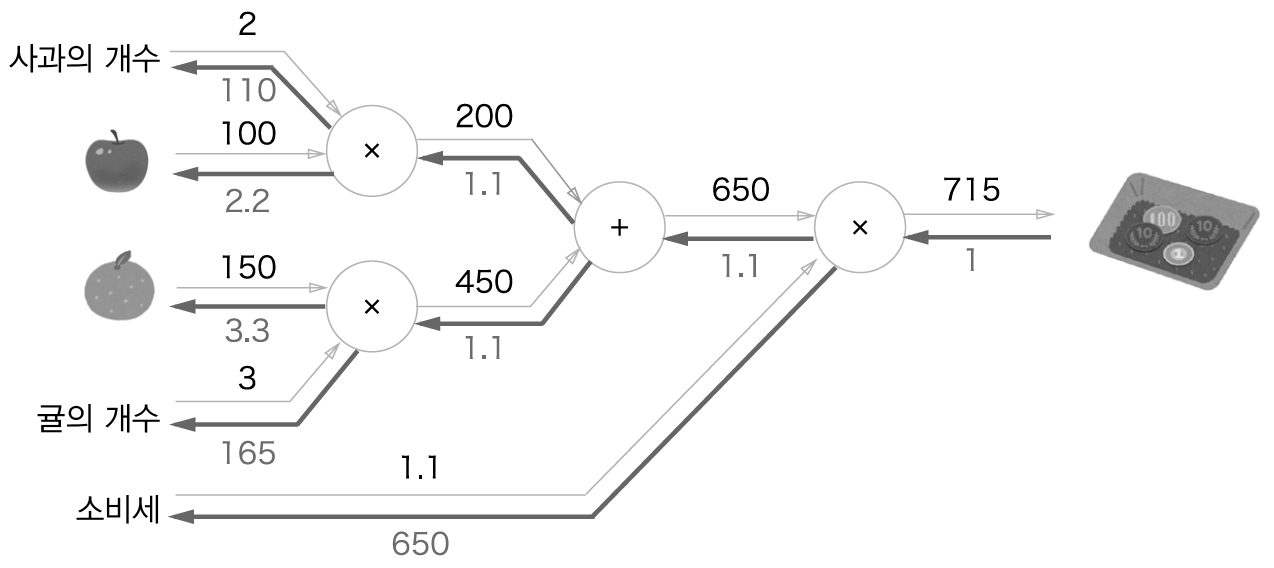

In [13]:
Image("image/fig 5-17.png")

In [14]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# 계층
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple, apple_num) # 곱하기
orange_price = mul_orange_layer.forward(orange, orange_num) # 곱하기
all_price = add_apple_orange_layer.forward(apple_price, orange_price) # 더하기
price = mul_tax_layer.forward(all_price, tax) # 곱하기

# 역전파
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print("price:", int(price))
print("dapple:", dapple)
print("dapple_num:", int(dapple_num))
print("dorange:", dorange)
print("dorange_num:", int(dorange_num))
print("dtax:", dtax)

price: 715
dapple: 2.2
dapple_num: 110
dorange: 3.3000000000000003
dorange_num: 165
dtax: 650


## 5.5 활성화 함수 계층 구현하기

### 5.5.1 ReLU 계층

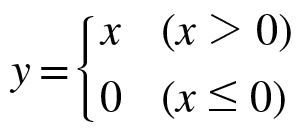

In [15]:
Image("image/e 5.7.png")

In [16]:
class Relu:
    
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0) # True, False 값들로 된 마스크 생성
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0 # 0보다 작은 값들에 대해서 미분값을 0으로 설정
        dx = dout

        return dx

### 5.5.2 Sigmoid 계층

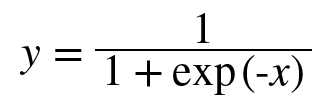

In [17]:
Image("image/e 5.9.png")

#### 순전파 계산 그래프

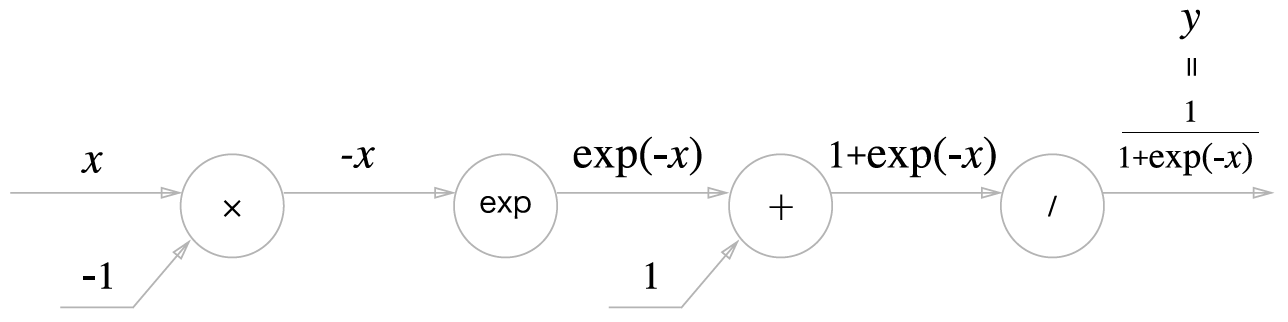

In [18]:
Image("image/fig 5-19.png")

#### **① '/' 노드**

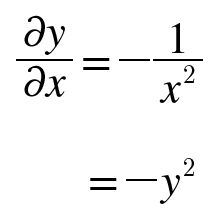

In [19]:
Image("image/e 5.10.png")

-> 상류에서 흘러온 미분 값에 순전파의 출력을 제곱한 후 마이너스를 붙인 값을 곱해서 하류로 전달

#### **② '+' 노드**

-> 상류의 값을 여과 없이 하류로 내보냄

#### **③ 'exp' 노드**

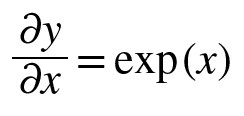

In [20]:
Image("image/e 5.11.png")

-> 상류의 값에 순전파 때의 출력을 곱해 하류로 전달

#### **④ 'X' 노드**

-> 순전파 때의 값을 서로 바꿔 곱한 후 전달

#### 최종 계산 그래프

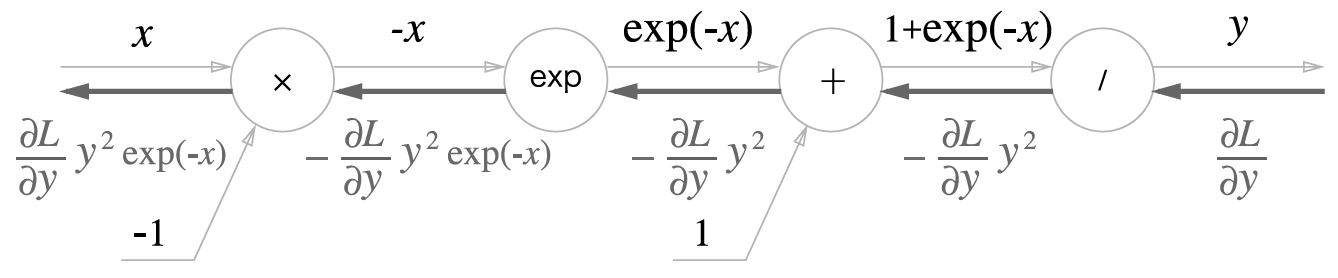

In [21]:
Image("image/fig 5-20.png")

**이를 단순화 시키면,**

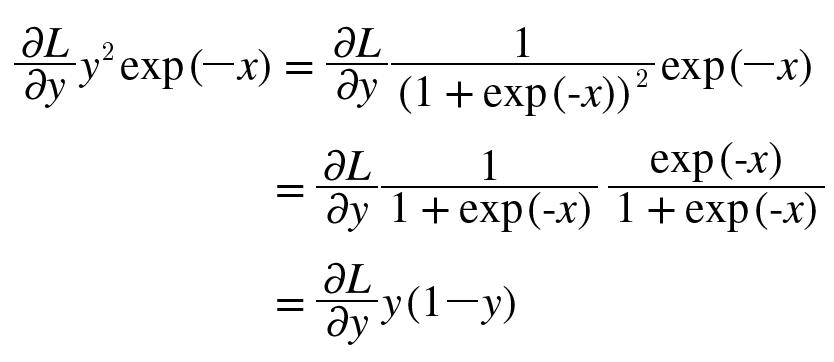

In [22]:
Image("image/e 5.12.png")

이처럼 **순전파의 출력만으로 계산할 수 있음!**

In [23]:
class Sigmoid:
    
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

## 5.6 Affine/Softmax 계층 구현하기

### 5.6.1 Affine 계층

신경망의 순전파 때 수행하는 행렬의 곱은 기하학에서는 **어파인변환**이라고 함!

#### 순전파

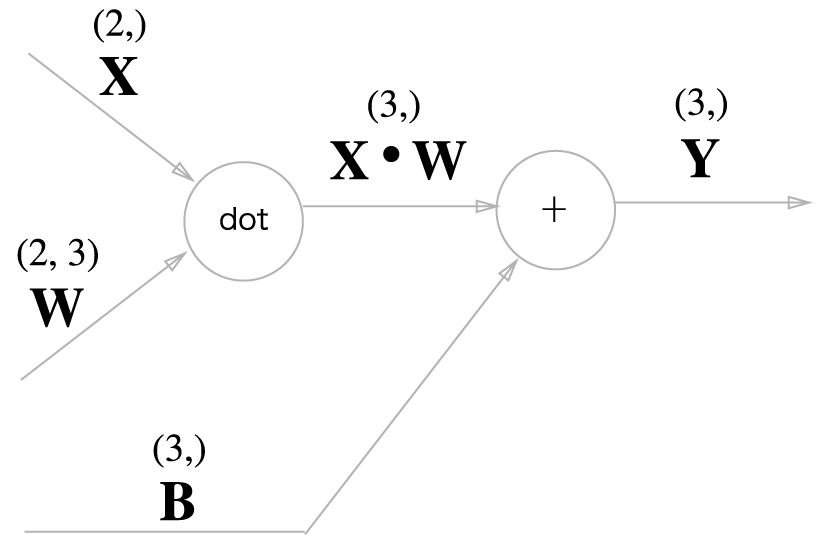

In [24]:
Image("image/fig 5-24.png")

#### 역전파

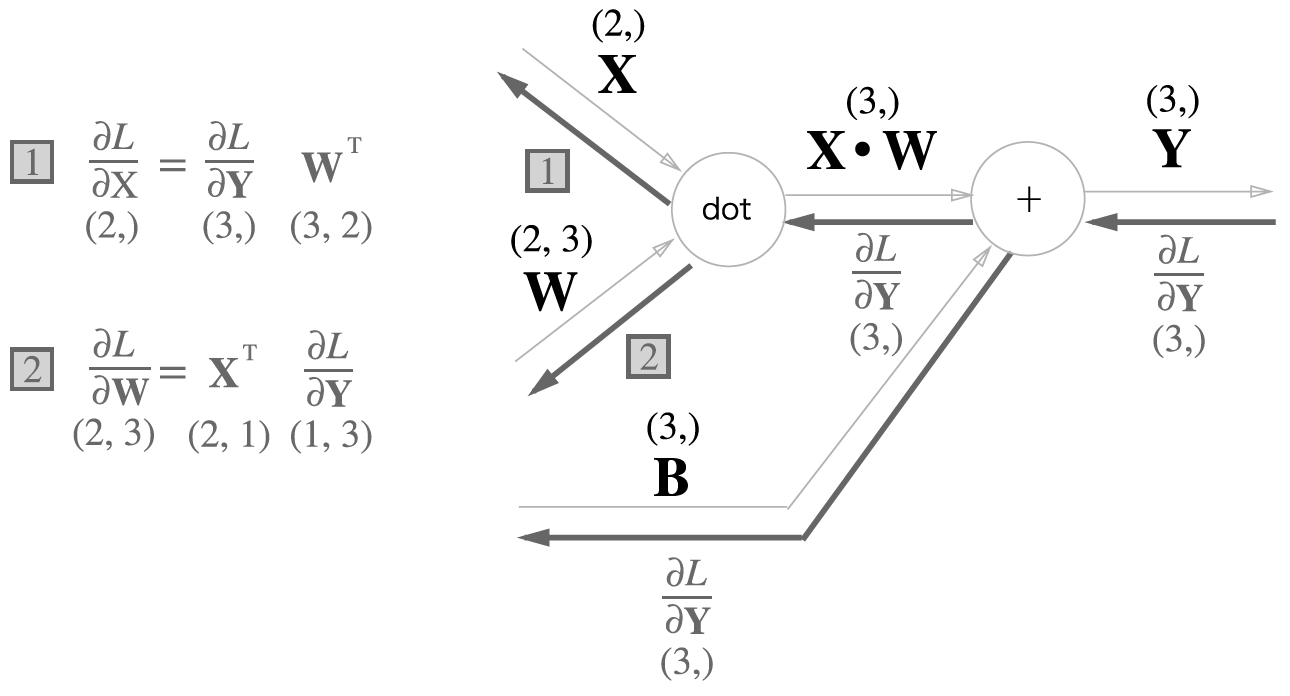

In [25]:
Image("image/fig 5-25.png")

In [26]:
class Affine:
    
    def __init__(self, W, b):
        
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        
        self.x = x
        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        return dx

### 5.6.3 Softmax-with-Loss 계층

**소프트맥스**: 출력층에서 사용, 입력값을 정규화하여 출력 </br>
손실함수인 교차 엔트로피 오차도 포함하여 'Softmax-with-Loss'계층이라 하자

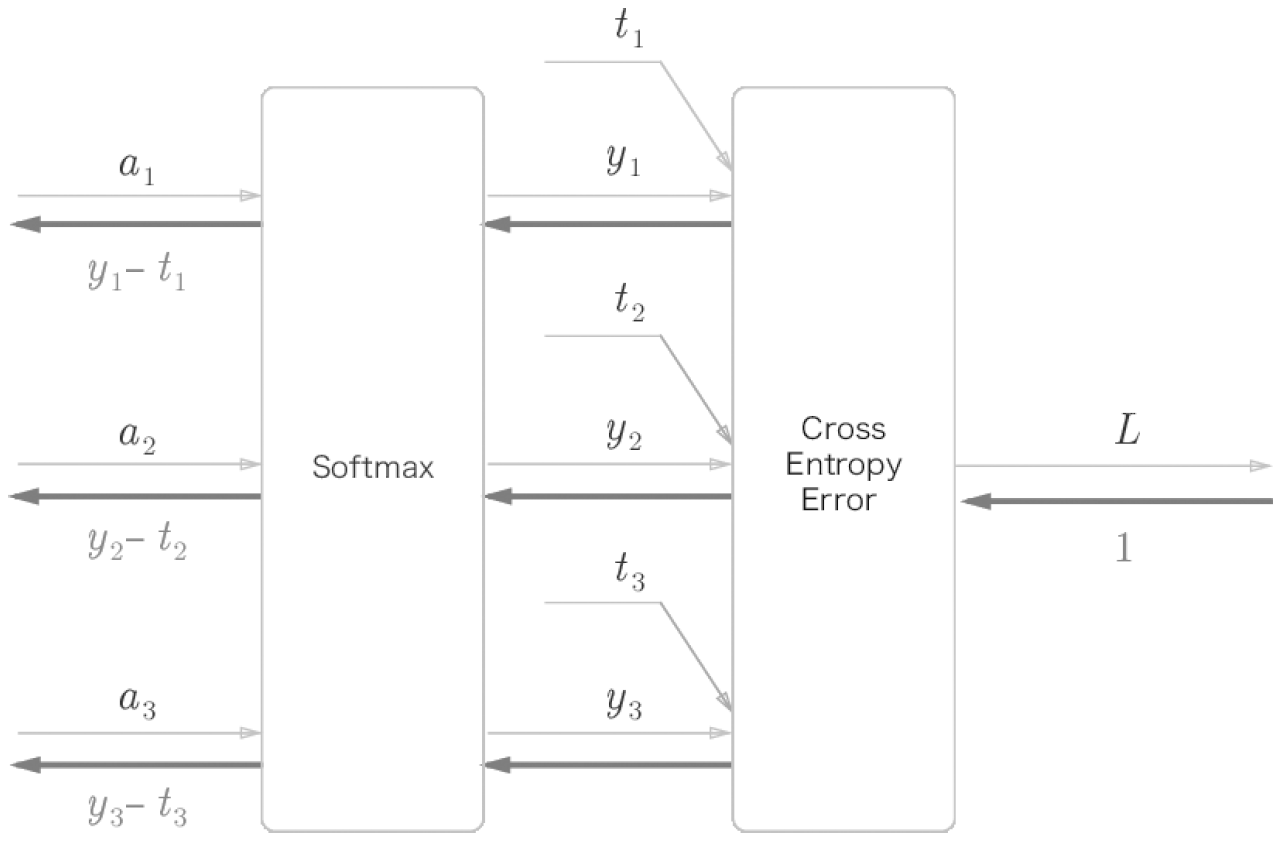

In [27]:
Image("image/fig 5-30.png")

- Softmax 계층의 역전파는 (y1-t1, y2-t2, y3-t3)이라는 깔끔한 결과를 내놓는 걸 볼 수 있음 (y는 출력값, t는 정답값)
- Softmax의 손실함수로 교차 엔트로피 오차 함수를 사용하고, 항등함수의 손실함수로 오차제곱합을 이용하면 이렇게 역전파의 결과가 말끔하게 떨어지게 됨
- 결과적으로 역전파를 통해 정답 레이블과 예측값 사이의 오차를 전파하게 되는 것!

#### 코드로 구현

In [28]:
class SoftmaxWithLoss:
    
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # 출력값
        self.t = None    # 정답 레이블
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y-self.t) / batch_size
        
        return dx

## 5.7 오차역전파법 구현하기

-> 앞 코드에서 역전파 부분만 추가수정

In [29]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict


class TwoLayerNet:

    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict() # 순서가 있는 딕셔너리
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
        
    def predict(self, x):
        
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
        
    
    def loss(self, x, t): # x : 입력 데이터, t : 정답 레이블
        
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    
    def accuracy(self, x, t):
        
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
        

    def numerical_gradient(self, x, t):
        
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
        
    def gradient(self, x, t):
        
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads